In [64]:
import hdf5storage
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from analysis_util import *
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.ticker import MaxNLocator


import seaborn as sns
'''this script test the hypothesis whether people respond to a fixed bound
pepole  '''
# global setting f
plt.rcParams.update({"font.size": 18})
colors = sns.color_palette("deep")
sns.set(style="whitegrid")
# top level dir 
# 


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression

In [65]:

PROJECT_DIR = "/data/rwchain-all/round2"
BEH_DIR = os.path.join(PROJECT_DIR, "rwchain-beh/data")
EEG_DIR = os.path.join(PROJECT_DIR, "rwchain-eeg")
ALL_BEH_DIR = os.path.join(PROJECT_DIR, 'rwchain-beh', 'combined')


In [66]:
CODE_DIR = "/home/jenny/evidence-chain/"
FIG_DIR = os.path.join(CODE_DIR, "figs/rw_logit/")

In [67]:
stimdur = '100'

In [68]:

list_of_subj = os.listdir(BEH_DIR)
list_of_subj.sort()
# list_of_subj = [list_of_subj[5]]

df = pd.read_pickle(os.path.join(ALL_BEH_DIR, 'all_df_concat.pkl'))
# organize some columsn
 
df['key'][df['key'] == '[5]'] = 1
df['key'][df['key'] == '[3]'] = 1
df['key'][df['key'] == '[2]'] = 0
df['cumsum'] = df['sequence_clean'].apply(lambda x: [sum(x[:i+1]) for i in range(len(x))])

# get rid of a ;pw acc subject
df = df[df['sid']!='s108']

if stimdur == '100':
    df = df[df['stimDur'] == 0.1]
if stimdur == '250':
    df = df[df['stimDur'] == 0.25]
# df = df[df['stimDur'] != 0.5]
# df = df[df['stimDur'] != 0.05]
# df = df[df['stimDur'] == 0.1]



/tmp/ipykernel_578372/100844696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[5]'] = 1
/tmp/ipykernel_578372/100844696.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[3]'] = 1
/tmp/ipykernel_578372/100844696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[2]'] = 0


In [69]:
# correct the count
df = correct_samples_by_condition(df)

cumsum = np.array(df['cumsum'].to_list())
sequence =  np.array(df['sequence_clean'].to_list())
count = df['count_corrected'].to_numpy()

In [70]:
df.shape

(3450, 13)

In [71]:
df.head()


,time,bytetime,press,count,key,stimDur,Bias,sequence,block,sequence_clean,sid,cumsum,count_corrected
100,1.3500020503997803,1345,[1],13,1,0.1,0.12,[ 1. -1. 1. -1. 1. -1. -1. 1. 1. 1. 1. ...,2,"[1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1...",s102,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, -1.0, 0.0, 1.0,...",11
101,1.249974012374878,1234,[1],12,0,0.1,0.12,[-1. -1. 1. 1. -1. -1. 1. 1. -1. 1. -1. -...,2,"[-1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -...",s102,"[-1.0, -2.0, -1.0, 0.0, -1.0, -2.0, -1.0, 0.0,...",10
102,1.399996042251587,1396,[1],13,1,0.1,0.12,[-1. -1. 1. -1. 1. -1. 1. 1. 1. -1. 1. ...,2,"[-1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1...",s102,"[-1.0, -2.0, -1.0, -2.0, -1.0, -2.0, -1.0, 0.0...",11
103,2.3166611194610596,2306,[1],23,1,0.1,0.12,[ 1. -1. 1. 1. 1. 1. -1. -1. -1. 1. -1. ...,2,"[1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1...",s102,"[1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 3.0, 2.0, 1.0, ...",21
104,1.0333290100097656,1017,[1],10,0,0.1,0.12,[-1. -1. -1. -1. 1. -1. 1. -1. -1. -1. 1. ...,2,"[-1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0,...",s102,"[-1.0, -2.0, -3.0, -4.0, -3.0, -4.0, -3.0, -4....",8


In [72]:
count.max()

29

In [73]:
# create a matrix of +1 and -1 with NaNs if the chain terminates

chain_matrix = get_chain_matrix(sequence, count)


In [74]:

# set the fixed bound


position_range = np.arange(2,23)

TRUE_N = []
TOTAL_N = []
FPR_TRAIN =[]
FPR_TEST =[]
TPR_TRAIN=[]
TPR_TEST=[]
AUC_TRAIN =[]
AUC_TEST =[]
POSITION_OF_SAMPLES=[]
N_TRAIN =[]
N_TEST = []
COEF =[] 
INTERCEPT= []
AUC_THRESH_TRAIN = []
AUC_THRESH_TEST =[]

for position_terminate in position_range:

    dataset, dataset_resp = make_dataset(position_terminate, count, chain_matrix)
    TRUE_N.append(dataset_resp.sum())
    TOTAL_N.append(len(dataset))
    x_train, x_test, y_train, y_test = train_test_split(
        dataset, dataset_resp, test_size=0.3, random_state=2024
    )
    N_TRAIN.append(len(x_train))
    N_TEST.append(len(x_test))
    # integrate evidence    
    x_train_evidence = get_abs_evidence(x_train)[:,0:]
    x_test_evidence = get_abs_evidence(x_test)[:,0:]

    # predict prob
    mymodel=LogisticRegression(fit_intercept=False)


    # mymodel=LogisticRegression(fit_intercept=True, penalty='l1', solver = 'liblinear')

    mymodel.fit(x_train_evidence,y_train)


    y_pred_prob_train = mymodel.predict_proba(x_train_evidence)
    y_pred_prob_test = mymodel.predict_proba(x_test_evidence)

    # plot ROC
    fpr_train, tpr_train, thresh_train = metrics.roc_curve(y_train, y_pred_prob_train[:,1])
    fpr_test, tpr_test, thresh_test = metrics.roc_curve(y_test, y_pred_prob_test[:,1])
    auc_train = metrics.auc(fpr_train, tpr_train)
    auc_test = metrics.auc(fpr_test, tpr_test)
    
    
    FPR_TRAIN.append(fpr_train)
    FPR_TEST.append(fpr_test)
    TPR_TRAIN.append(tpr_train)
    TPR_TEST.append(tpr_test)
    AUC_TRAIN.append(auc_train)
    AUC_TEST.append(auc_test)
    POSITION_OF_SAMPLES.append(position_terminate)
    AUC_THRESH_TRAIN.append(thresh_train)
    AUC_THRESH_TEST.append(thresh_test)
    COEF.append(mymodel.coef_)
    INTERCEPT.append(mymodel.intercept_)
    # plt.scatter(x_train_evidence,y_pred_prob_train)
    # plt.show()

In [75]:
# def plot_performance_matrix(performance_matrix):
#     fig, ax = plt.subplots(1,1,figsize = (6,4))
#     performance_matrix = np.ma.masked_where(performance_matrix==0,performance_matrix)
#     cmap = mpl.cm.get_cmap("OrRd").copy()

#     cmap.set_bad(color='black')
#     # plt.imshow(performance_matrix_train,interpolation='none', vmin=0.5, vmax=1, cmap = "OrRd")
#     ax.set_ylabel("level of evidence integrated")
#     ax.set_xlabel("position at termination")
#     ax.set_xticks(np.arange(1, max(position_range)+2))
#     ax.set_yticks(fixed_bound)

#     # plt.colorbar()
#     im = ax.pcolor(performance_matrix, vmin=0.5, vmax=0.8, cmap = cmap,edgecolors='k', linewidths=1)
#     fig.colorbar(im)
#     return fig, ax

In [76]:
# performance_matrix_train = np.zeros((max(fixed_bound), max(position_range+1)))
# performance_matrix_test = np.zeros((max(fixed_bound), max(position_range+1)))

In [77]:
# fig, ax = plot_performance_matrix(performance_matrix_test)

In [78]:
GMEANS_train=[]
IDX_train=[]
for i in range(len(TPR_TRAIN)):
    gmeans = np.sqrt(TPR_TRAIN[i] * (1-FPR_TRAIN[i]))
    ix = np.argmax(gmeans)
    GMEANS_train.append(AUC_THRESH_TRAIN[i][ix])
    IDX_train.append(ix)
    

In [79]:
GMEANS_test=[]
IDX_test=[]
for i in range(len(TPR_TEST)):
    gmeans = get_gmeans(TPR_TEST[i], FPR_TEST[i])
    ix = np.argmax(gmeans)
    GMEANS_test.append(AUC_THRESH_TEST[i][ix])
    IDX_test.append(ix)

/tmp/ipykernel_578372/513116939.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


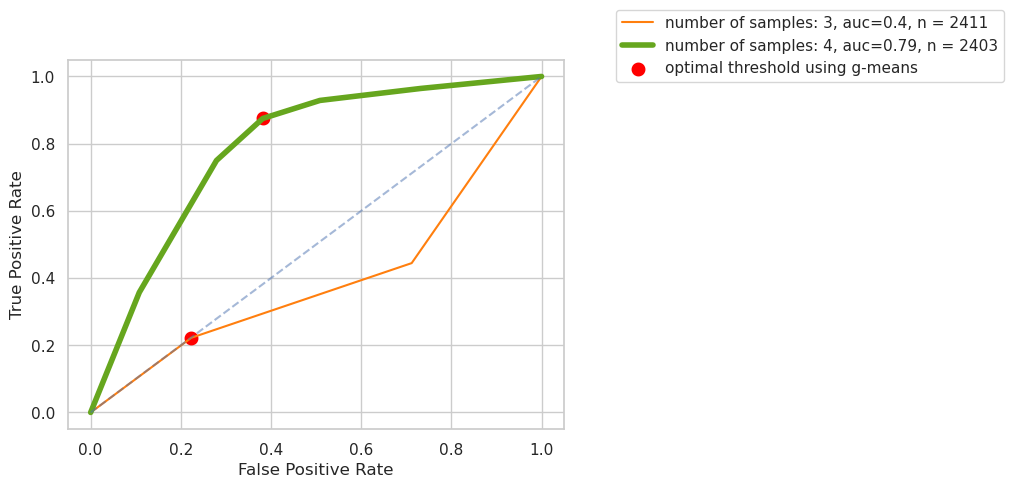

In [80]:
fig,ax = plot_roc(FPR_TRAIN[0:2],TPR_TRAIN[0:2],AUC_TRAIN[0:2], position_range[0:2]+1, N_TRAIN[0:2], auc_cutoff = 0.1)
ax.scatter(FPR_TRAIN[0][IDX_train[0]], TPR_TRAIN[0][IDX_train[0]], color = 'red', lw = 4, label="optimal threshold using g-means")
ax.scatter(FPR_TRAIN[1][IDX_train[1]], TPR_TRAIN[1][IDX_train[1]], color = 'red', lw = 4)
ax.get_legend().remove()
fig.legend(bbox_to_anchor=(0.6,1,1,0))
fig.show()
fig.savefig(f'{FIG_DIR}gmean_demo_{stimdur}.png', dpi=300, bbox_inches='tight')


/tmp/ipykernel_578372/4033406557.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


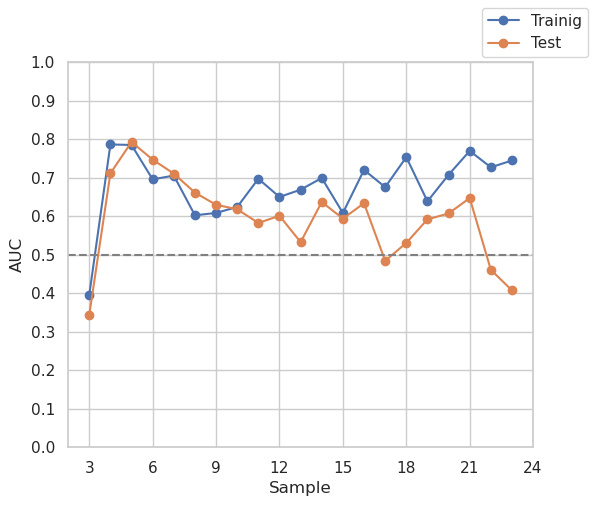

In [81]:
fig, ax = plot_roc_per_sample_position(POSITION_OF_SAMPLES, AUC_TRAIN, AUC_TEST)
ax.axhline(y=0.5, color ='grey', ls='--')
# ax.set_xticks([i+1 for i in POSITION_OF_SAMPLES])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_yticks(np.arange(0,1.1,0.1))
fig.set_size_inches(6, 5)
fig.savefig(f'{FIG_DIR}auc_lines_{stimdur}.png', dpi=300,bbox_inches='tight')

fig.show()

/tmp/ipykernel_578372/2530502256.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


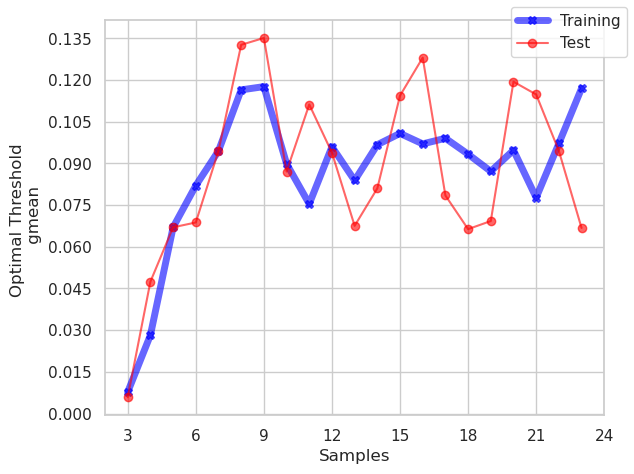

In [82]:
fig, ax = plt.subplots(1,1)
ax.plot(position_range+1, [i for i in GMEANS_train], linewidth=5, marker = 'X', alpha=0.6, color='blue', label = 'Training')
ax.plot(position_range+1, [i for i in GMEANS_test], marker = 'o', alpha=0.6, color= 'red', label = 'Test')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Samples")
ax.set_ylabel("Optimal Threshold \n gmean")

# ax.set_ylim(1,10)
fig.legend()
fig.tight_layout()
fig.savefig(f'{FIG_DIR}threshold_per_sample_{stimdur}.png', dpi=300,bbox_inches='tight')
fig.show()



/tmp/ipykernel_578372/1499294374.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


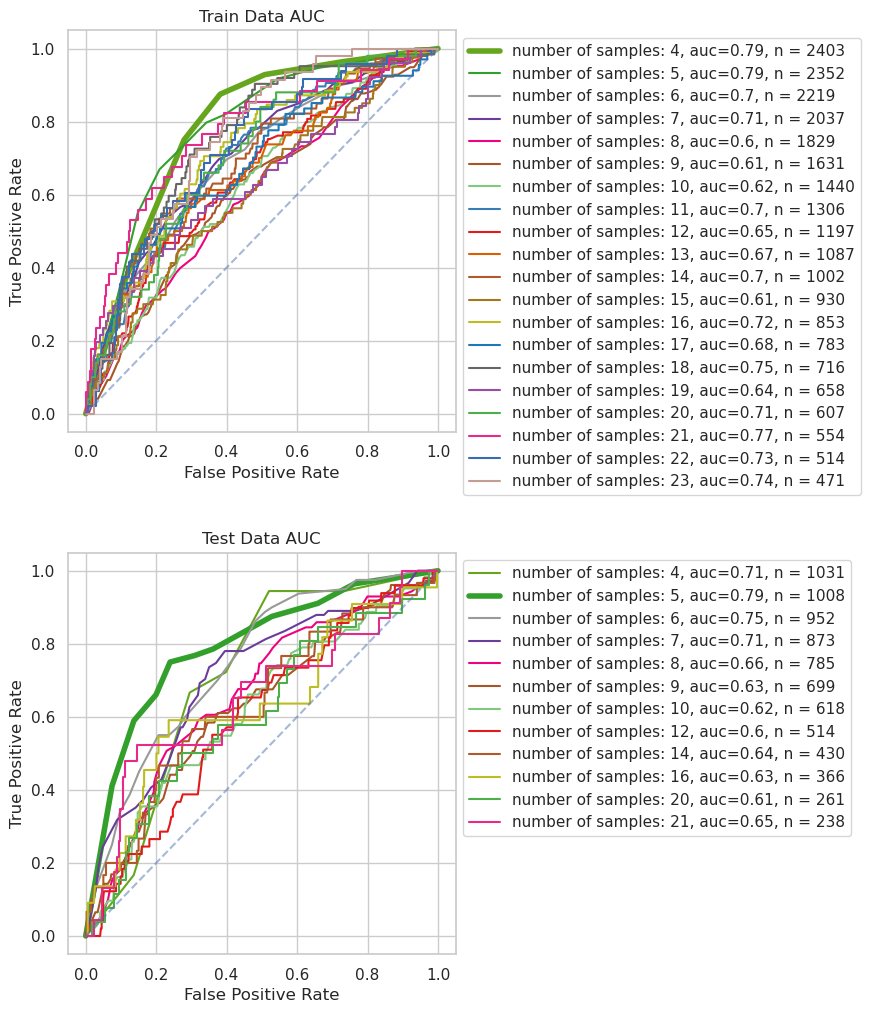

In [83]:
fig, ax = plt.subplots(2,1,figsize = (5,12))
_,ax0 = plot_roc(FPR_TRAIN,TPR_TRAIN,AUC_TRAIN, position_range+1, N_TRAIN, auc_cutoff = 0.6, ax=ax[0])
_,ax1 = plot_roc(FPR_TEST,TPR_TEST,AUC_TEST, position_range+1, N_TEST, auc_cutoff = 0.6, ax=ax[1])
ax0.set_title("Train Data AUC")
ax1.set_title("Test Data AUC")
fig.subplots_adjust(hspace=0.3)
fig.show()
fig.savefig(f'{FIG_DIR}auc_curve_{stimdur}.png', dpi=300,bbox_inches='tight')



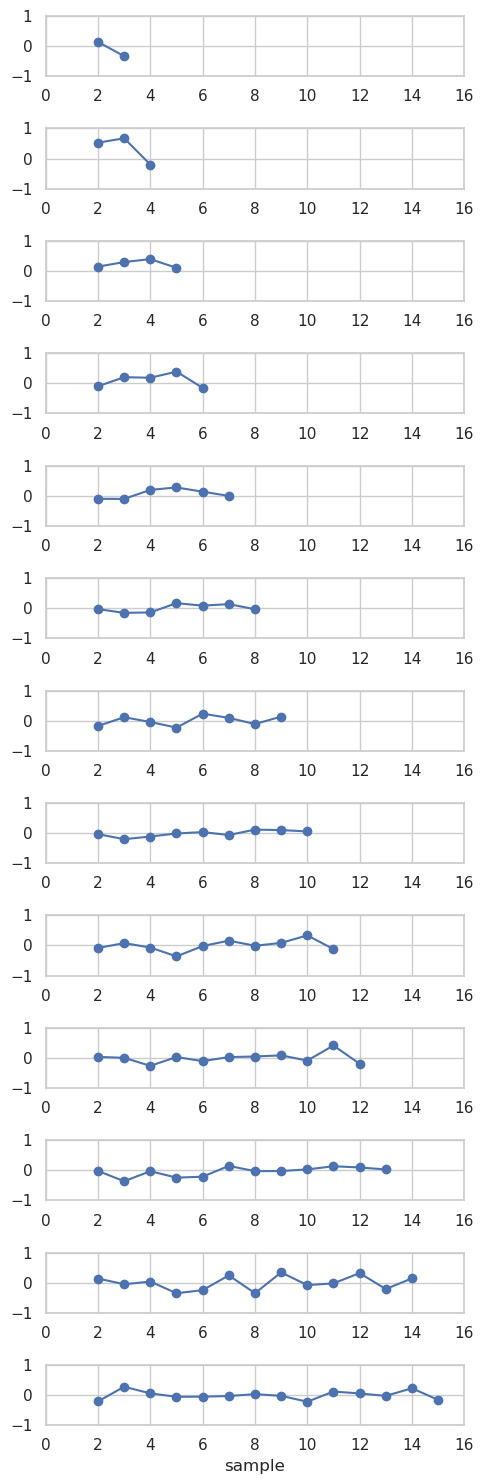

In [84]:
maxSample = max(position_range)
beg_ind =0
ind_end = 13
fig, ax1 = plt.subplots(nrows=ind_end, figsize = (5,15))
for ind, j in enumerate(COEF[:ind_end]):
    
    pos = position_range[ind] +1
    # plt.plot(np.arange(ind, maxSample+1), j[0], label = str(len(j[0])), marker = 'o')
    ax1[ind].plot(np.arange(2, pos+1), j[0][1:], label = str(len(j[0])), marker = 'o')
    # fig.show()
    ax1[ind].set_xlim(0,ind_end+3)
    ax1[ind].set_ylim(-1,1)
    ax1[ind].xaxis.set_major_locator(MaxNLocator(integer=True))
ax1[ind].set_xlabel("sample")
fig.tight_layout()
fig.savefig(f'{FIG_DIR}coefficient_{stimdur}.png', dpi=300,bbox_inches='tight')

